# Exploratory Data Analysis: WA State Databreaches

## Imports

In [2]:
import matplotlib.pyplot as plt
from math import ceil
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix
import pylab as py

In [3]:
# formatting for pandas to display the numbers pulled from the dataframe differently (keeps it from doing scientific notation)
pd.options.display.float_format = '{:.0f}'.format

In [4]:
databreach_df = pd.read_csv('../data/WA_Databreach_20231102.csv')
databreach_df.head()

,DateAware,DateSubmitted,DataBreachCause,DateStart,DateEnd,Name,Id,CyberattackType,WashingtoniansAffected,IndustryType,...,BreachLifecycleRange,DaysToContainBreach,DaysToIdentifyBreach,DaysBreachLifecycle,DiscoveredInProgress,DaysOfExposure,DaysElapsedBetweenEndAndDiscovery,EndedOnDayDiscovered,DaysElapsedBeforeNotification,DaysOfExposureRange
0,09/20/2017 12:00:00 AM,11/15/2017 12:00:00 AM,Theft or Mistake,09/20/2017 12:00:00 AM,09/20/2017 12:00:00 AM,Western State Hospital,9750,NaN,515,Health,...,0,0,0,0,True,0,NaN,True,56,0
1,11/15/2016 12:00:00 AM,11/21/2017 12:00:00 AM,Cyberattack,10/13/2016 12:00:00 AM,11/15/2016 12:00:00 AM,"Uber Technologies, Inc.",9752,NaN,10888,Business,...,1-99,0,33,33,True,33,NaN,True,371,1-99
2,NaN,11/27/2017 12:00:00 AM,Cyberattack,10/26/2016 12:00:00 AM,10/19/2017 12:00:00 AM,"Bulletproof 360, Inc.",9753,Malware,4077,Business,...,Unknown,NaN,NaN,NaN,False,358,NaN,False,NaN,300-399
3,09/06/2017 12:00:00 AM,12/01/2017 12:00:00 AM,Unauthorized Access,06/15/2016 12:00:00 AM,11/06/2017 12:00:00 AM,JAM Paper & Envelope,9754,NaN,590,Business,...,500+,61,448,509,True,509,NaN,False,86,500+
4,10/06/2017 12:00:00 AM,12/11/2017 12:00:00 AM,Cyberattack,07/01/2015 12:00:00 AM,10/06/2017 12:00:00 AM,"Combat Brands, LLC",9755,Malware,956,Business,...,500+,0,828,828,True,828,NaN,True,66,500+


## Simple EDA Stuff

In [5]:
databreach_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   DateAware                          966 non-null    object 
 1   DateSubmitted                      990 non-null    object 
 2   DataBreachCause                    990 non-null    object 
 3   DateStart                          862 non-null    object 
 4   DateEnd                            804 non-null    object 
 5   Name                               990 non-null    object 
 6   Id                                 990 non-null    int64  
 7   CyberattackType                    649 non-null    object 
 8   WashingtoniansAffected             958 non-null    float64
 9   IndustryType                       990 non-null    object 
 10  BusinessType                       467 non-null    object 
 11  Year                               990 non-null    int64  

Columns to use: DataBreachCause, WashingtoniansAffected, IndustryType, BusinessType, Year, DaysToContainBreach, DaysToIdentifyBreach, DaysBreachLifecycle, DiscoveredInProgress, DaysOfExposure, EndedOnDayDiscovered

In [6]:
databreach_df.describe()

,Id,WashingtoniansAffected,Year,YearText,DaysToContainBreach,DaysToIdentifyBreach,DaysBreachLifecycle,DaysOfExposure,DaysElapsedBetweenEndAndDiscovery,DaysElapsedBeforeNotification
count,990,958,990,990,787,842,769,786,399,966
mean,11658,26416,2021,2021,6,140,145,111,76,86
std,2060,157571,2,2,29,294,267,223,203,91
min,9561,15,2016,2016,0,-350,0,0,1,0
25%,10271,842,2020,2020,0,4,7,2,12,30
50%,10550,1691,2021,2021,0,38,50,32,57,52
75%,13580,6209,2022,2022,0,160,169,103,80,107
max,15868,3243664,2024,2024,365,3728,3728,2240,3453,638


## Trim the df

In [7]:
regress_test_df = databreach_df.drop(['DateAware', 'DateSubmitted', 'DateStart', 'DateEnd', 'Name', 'Id', 'YearText', 'WashingtoniansAffectedRange', 'BreachLifecycleRange', 'DaysElapsedBetweenEndAndDiscovery', 'DaysOfExposureRange'], axis=1)

In [8]:
regress_test_df.head()

,DataBreachCause,CyberattackType,WashingtoniansAffected,IndustryType,BusinessType,Year,DaysToContainBreach,DaysToIdentifyBreach,DaysBreachLifecycle,DiscoveredInProgress,DaysOfExposure,EndedOnDayDiscovered,DaysElapsedBeforeNotification
0,Theft or Mistake,NaN,515,Health,NaN,2018,0,0,0,True,0,True,56
1,Cyberattack,NaN,10888,Business,Transportation,2018,0,33,33,True,33,True,371
2,Cyberattack,Malware,4077,Business,Consumable,2018,NaN,NaN,NaN,False,358,False,NaN
3,Unauthorized Access,NaN,590,Business,Manufacturing,2018,61,448,509,True,509,False,86
4,Cyberattack,Malware,956,Business,Fitness,2018,0,828,828,True,828,True,66


In [9]:
regress_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DataBreachCause                990 non-null    object 
 1   CyberattackType                649 non-null    object 
 2   WashingtoniansAffected         958 non-null    float64
 3   IndustryType                   990 non-null    object 
 4   BusinessType                   467 non-null    object 
 5   Year                           990 non-null    int64  
 6   DaysToContainBreach            787 non-null    float64
 7   DaysToIdentifyBreach           842 non-null    float64
 8   DaysBreachLifecycle            769 non-null    float64
 9   DiscoveredInProgress           990 non-null    bool   
 10  DaysOfExposure                 786 non-null    float64
 11  EndedOnDayDiscovered           990 non-null    bool   
 12  DaysElapsedBeforeNotification  966 non-null    flo

## Refine the DF
- patch holes, combine category/subcategory sets of columns, then possibly get dummies

In [10]:
regress_test_df.loc[:, 'CyberattackType'][(regress_test_df['DataBreachCause'] == 'Cyberattack') 
                                                & (regress_test_df['CyberattackType'].isnull())] = 'Unreported'
                            
regress_test_df.sample(8)

C:\Users\RGBMonster\AppData\Local\Temp\ipykernel_13260\2387569062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regress_test_df.loc[:, 'CyberattackType'][(regress_test_df['DataBreachCause'] == 'Cyberattack')


,DataBreachCause,CyberattackType,WashingtoniansAffected,IndustryType,BusinessType,Year,DaysToContainBreach,DaysToIdentifyBreach,DaysBreachLifecycle,DiscoveredInProgress,DaysOfExposure,EndedOnDayDiscovered,DaysElapsedBeforeNotification
416,Cyberattack,Ransomware,17908,Non-Profit/Charity,NaN,2021,0,160,160,False,103,False,29
408,Cyberattack,Unreported,NaN,Business,Software,2021,NaN,114,NaN,False,NaN,False,89
124,Theft or Mistake,NaN,6300,Business,Other,2017,NaN,0,NaN,False,NaN,False,43
642,Cyberattack,Malware,9581,Business,Web Services,2022,NaN,72,NaN,False,NaN,False,6
48,Cyberattack,Malware,2696,Business,Accessories,2017,NaN,NaN,NaN,False,NaN,False,43
813,Cyberattack,Ransomware,1368,Business,Other,2023,0,52,52,True,52,True,159
828,Cyberattack,Ransomware,2752,Health,NaN,2023,0,2,2,True,2,True,60
783,Cyberattack,Ransomware,505,Business,Other,2023,0,49,49,False,16,False,29


In [11]:
regress_test_df['DataBreachCause'].unique()

array(['Theft or Mistake', 'Cyberattack', 'Unauthorized Access'],
      dtype=object)

In [12]:
regress_test_df['CyberattackType'].unique()

array([nan, 'Unreported', 'Malware', 'Phishing', 'Other', 'Skimmers',
       'Ransomware', 'Unclear/unknown'], dtype=object)

In [13]:
# regress_test_df['Cyberattack&Breach_Cause'] = regress_test_df['DataBreachCause'] + regress_test_df['CyberattackType'].astype(str).apply(lambda x: "" if x == 'nan' else ' '+x)
# def combcats()
# regress_test_df['Cyberattack&Breach_Cause']

In [14]:
regress_test_df.sample(8)

,DataBreachCause,CyberattackType,WashingtoniansAffected,IndustryType,BusinessType,Year,DaysToContainBreach,DaysToIdentifyBreach,DaysBreachLifecycle,DiscoveredInProgress,DaysOfExposure,EndedOnDayDiscovered,DaysElapsedBeforeNotification
683,Cyberattack,Ransomware,1493,Business,Professional Services,2022,0,0,0,True,0,True,192
74,Cyberattack,Other,1688,Finance,NaN,2017,0,12,12,False,0,False,57
684,Unauthorized Access,Other,729,Business,Other,2022,0,24,24,True,24,True,38
735,Cyberattack,Ransomware,18346,Finance,NaN,2022,0,4,4,True,4,True,125
823,Cyberattack,Other,890,Finance,NaN,2023,0,2,2,True,2,True,41
921,Cyberattack,Unclear/unknown,1414,Business,Retail,2024,0,561,561,False,385,False,48
651,Cyberattack,Malware,4774,Business,Software,2022,NaN,6,NaN,False,NaN,False,49
829,Cyberattack,Malware,1242,Business,Retail,2023,0,529,529,False,503,False,186


In [15]:
regress_test_df['IndustryType'].value_counts()

Business              463
Health                159
Finance               150
Non-Profit/Charity     99
Education              81
Government             38
Name: IndustryType, dtype: int64

In [16]:
regress_test_df['Industry&Business_Type'] = regress_test_df['IndustryType'] + regress_test_df['BusinessType'].astype(str).apply(lambda x: "" if x == 'nan' else ' '+x)

In [17]:
regress_test_df['Industry&Business_Type'].value_counts()

Health                            157
Finance                           148
Business Retail                   100
Non-Profit/Charity                 99
Education                          81
Business Other                     78
Business Hospitality               41
Government                         38
Business Manufacturing             28
Business Professional Services     27
Business Software                  23
Business Clothing                  19
Business Consumable                19
Business Legal                     16
Business Entertainment             15
Business Construction              13
Business Transportation            12
Business Cosmetic                   9
Business Web Services               8
Business Accessories                8
Business Human Resources            8
Business Telecommunications         8
Business Shipping                   7
Business Home                       6
Business Fitness                    6
Business Real Estate                6
Business Cle

Looking at this, I'm going to say that Business type is not particularly useful at this time, as that level of subcategorization is not needed for this approach.

In [18]:
# regress_test_df['Cyberattack&Breach_Cause'].value_counts()

In [19]:
# regress_test_df.drop(['DataBreachCause', 'CyberattackType', 'BusinessType', 'Industry&Business_Type'], inplace=True, axis=1)

In [20]:
regress_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DataBreachCause                990 non-null    object 
 1   CyberattackType                710 non-null    object 
 2   WashingtoniansAffected         958 non-null    float64
 3   IndustryType                   990 non-null    object 
 4   BusinessType                   467 non-null    object 
 5   Year                           990 non-null    int64  
 6   DaysToContainBreach            787 non-null    float64
 7   DaysToIdentifyBreach           842 non-null    float64
 8   DaysBreachLifecycle            769 non-null    float64
 9   DiscoveredInProgress           990 non-null    bool   
 10  DaysOfExposure                 786 non-null    float64
 11  EndedOnDayDiscovered           990 non-null    bool   
 12  DaysElapsedBeforeNotification  966 non-null    flo

In [21]:
regress_test_df.dropna(inplace=True)

# regress_test_df = regress_test_df[((regress_test_df['Cyberattack&Breach_Cause'] != 'Unauthorized Access Phishing') & 
# (regress_test_df['Cyberattack&Breach_Cause'] != 'Unauthorized Access Ransomware') &
# (regress_test_df['Cyberattack&Breach_Cause'] != 'Unauthorized Access Other') & 
# (regress_test_df['Cyberattack&Breach_Cause'] != 'Unauthorized Access Unclear/unknown'))]

regress_test_df.reset_index(inplace=True)
regress_test_df.drop('index', axis=1, inplace=True)
regress_test_df

,DataBreachCause,CyberattackType,WashingtoniansAffected,IndustryType,BusinessType,Year,DaysToContainBreach,DaysToIdentifyBreach,DaysBreachLifecycle,DiscoveredInProgress,DaysOfExposure,EndedOnDayDiscovered,DaysElapsedBeforeNotification,Industry&Business_Type
0,Cyberattack,Unreported,10888,Business,Transportation,2018,0,33,33,True,33,True,371,Business Transportation
1,Cyberattack,Malware,956,Business,Fitness,2018,0,828,828,True,828,True,66,Business Fitness
2,Cyberattack,Malware,21687,Business,Hospitality,2018,0,623,623,False,547,False,16,Business Hospitality
3,Cyberattack,Unreported,5013,Business,Hospitality,2018,0,151,151,False,82,False,19,Business Hospitality
4,Cyberattack,Malware,1634,Business,Fitness,2018,0,0,0,True,0,True,30,Business Fitness
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,Cyberattack,Skimmers,1929,Business,Retail,2024,0,560,560,False,385,False,134,Business Retail
257,Cyberattack,Ransomware,532,Business,Manufacturing,2024,0,7,7,True,7,True,33,Business Manufacturing
258,Cyberattack,Other,2319,Business,Software,2024,2,385,387,True,387,False,67,Business Software
259,Cyberattack,Ransomware,805,Business,Clothing,2024,0,19,19,True,19,True,237,Business Clothing


## Expirement with handling NaNs

In [23]:
breach_lasted_column = databreach_df['DaysBreachLifecycle']

In [24]:
mean = breach_lasted_column.mean()
mean

145.38231469440834

In [25]:
stdev = breach_lasted_column.std()
stdev

266.791096294128

In [26]:
loc = mean

scale = stdev

left = 0

right = np.inf

a = (left-loc)/scale
b = (right-loc)/scale

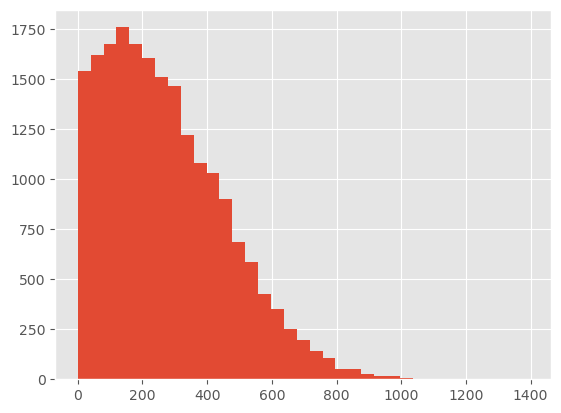

In [27]:
true_dist = stats.truncnorm(a,b,loc,scale)
true_samp = true_dist.rvs(20000)

plt.hist(true_samp, bins=35)

plt.show()

In [28]:
def replace_nans(value):
    
    if np.isnan(value):
        return int(true_dist.rvs(1))

    else:
        return(value)

In [54]:
replace_nans(12)

12

In [30]:
mean

145.38231469440834

In [31]:
databreach_df['DaysBreachLifecycle'].apply(replace_nans).mean()


171.11212121212122

## Initial regression testing

In [32]:
# regress_test_df = pd.get_dummies(regress_test_df, columns=['IndustryType', 'Cyberattack&Breach_Cause']).drop(['IndustryType_Business', 'Cyberattack&Breach_Cause_Cyberattack Ransomware'], axis =1)

In [33]:
regress_test_df.columns

Index(['DataBreachCause', 'CyberattackType', 'WashingtoniansAffected',
       'IndustryType', 'BusinessType', 'Year', 'DaysToContainBreach',
       'DaysToIdentifyBreach', 'DaysBreachLifecycle', 'DiscoveredInProgress',
       'DaysOfExposure', 'EndedOnDayDiscovered',
       'DaysElapsedBeforeNotification', 'Industry&Business_Type'],
      dtype='object')

In [34]:
X = pd.get_dummies(regress_test_df['IndustryType']).drop('Business', axis=1)

y = regress_test_df['WashingtoniansAffected']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [36]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [37]:
X = sm.add_constant(X)

model = sm.OLS(y,X).fit()
predictions = model.predict(X)
res = model.resid

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     WashingtoniansAffected   R-squared:                       0.367
Model:                                OLS   Adj. R-squared:                  0.362
Method:                     Least Squares   F-statistic:                     74.67
Date:                    Mon, 13 Nov 2023   Prob (F-statistic):           2.60e-26
Time:                            17:34:03   Log-Likelihood:                -3084.5
No. Observations:                     261   AIC:                             6175.
Df Residuals:                         258   BIC:                             6186.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6927.4225   2055.997      3.369      0.001    2878.750     1.1e+04
Finance    -2409.4225   3.31e+04     -0.073      0.942   -6.76e+04    6.27e+04
Health      2.865e+05   2.34e+04     12.220      0.000     2.4e+05    3.33e+05
==============================================================================
Omnibus:                      169.226   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26528.839
Skew:                           1.483   Prob(JB):                         0.00
Kurtosis:                      52.302   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# X = pd.get_dummies(regress_test_df['Cyberattack&Breach_Cause']).drop('Cyberattack Ransomware', axis=1)

y = regress_test_df['WashingtoniansAffected']

In [39]:
X

,const,Finance,Health
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
256,1,0,0
257,1,0,0
258,1,0,0
259,1,0,0


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [41]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [42]:
X = sm.add_constant(X)

model = sm.OLS(y,X).fit()
predictions = model.predict(X)
res = model.resid

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     WashingtoniansAffected   R-squared:                       0.367
Model:                                OLS   Adj. R-squared:                  0.362
Method:                     Least Squares   F-statistic:                     74.67
Date:                    Mon, 13 Nov 2023   Prob (F-statistic):           2.60e-26
Time:                            17:34:04   Log-Likelihood:                -3084.5
No. Observations:                     261   AIC:                             6175.
Df Residuals:                         258   BIC:                             6186.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6927.4225   2055.997      3.369      0.001    2878.750     1.1e+04
Finance    -2409.4225   3.31e+04     -0.073      0.942   -6.76e+04    6.27e+04
Health      2.865e+05   2.34e+04     12.220      0.000     2.4e+05    3.33e+05
==============================================================================
Omnibus:                      169.226   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26528.839
Skew:                           1.483   Prob(JB):                         0.00
Kurtosis:                      52.302   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# X = pd.get_dummies(regress_test_df.loc[:, ['Cyberattack&Breach_Cause', 'IndustryType', 'DaysOfExposure']]).drop(['IndustryType_Business','Cyberattack&Breach_Cause_Cyberattack Ransomware'] , axis=1)

In [44]:
X

,const,Finance,Health
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
256,1,0,0
257,1,0,0
258,1,0,0
259,1,0,0


In [45]:
X = sm.add_constant(X)

model = sm.OLS(y,X).fit()
predictions = model.predict(X)
res = model.resid

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     WashingtoniansAffected   R-squared:                       0.367
Model:                                OLS   Adj. R-squared:                  0.362
Method:                     Least Squares   F-statistic:                     74.67
Date:                    Mon, 13 Nov 2023   Prob (F-statistic):           2.60e-26
Time:                            17:34:06   Log-Likelihood:                -3084.5
No. Observations:                     261   AIC:                             6175.
Df Residuals:                         258   BIC:                             6186.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6927.4225   2055.997      3.369      0.001    2878.750     1.1e+04
Finance    -2409.4225   3.31e+04     -0.073      0.942   -6.76e+04    6.27e+04
Health      2.865e+05   2.34e+04     12.220      0.000     2.4e+05    3.33e+05
==============================================================================
Omnibus:                      169.226   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26528.839
Skew:                           1.483   Prob(JB):                         0.00
Kurtosis:                      52.302   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
model.params

const       6927
Finance    -2409
Health    286455
dtype: float64

In [47]:
X = pd.get_dummies(regress_test_df['DataBreachCause']).drop('Cyberattack', axis=1)

In [48]:
X

,Unauthorized Access
0,0
1,0
2,0
3,0
4,0
...,...
256,0
257,0
258,0
259,0


In [49]:
X = sm.add_constant(X)

model = sm.OLS(y,X).fit()
predictions = model.predict(X)
res = model.resid

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     WashingtoniansAffected   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.004
Method:                     Least Squares   F-statistic:                   0.05240
Date:                    Mon, 13 Nov 2023   Prob (F-statistic):              0.819
Time:                            17:34:08   Log-Likelihood:                -3144.1
No. Observations:                     261   AIC:                             6292.
Df Residuals:                         259   BIC:                             6299.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                9164.8108   2573.168      3.562      0.000    4097.817    1.42e+04
Unauthorized Access -6728.8108   2.94e+04     -0.229      0.819   -6.46e+04    5.12e+04
==============================================================================
Omnibus:                      492.608   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           224963.350
Skew:                          10.980   Prob(JB):                         0.00
Kurtosis:                     145.141   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""